In [5]:
import pandas as pd
import numpy as np
import cv2
import os

In [7]:
filelist_df = pd.read_csv('EchoNet-Dynamic/FileList.csv')

# Cargar el archivo VolumeTracings.csv
volumetracings_df = pd.read_csv('EchoNet-Dynamic/VolumeTracings.csv')

In [69]:
videos = ['0X100009310A3BD7FC.avi', '0X1002E8FBACD08477.avi', '0X1005D03EED19C65B.avi', '0X10075961BC11C88E.avi', '0X10094BA0A028EAC3.avi', 
          '0X100CF05D141FF143.avi', '0X100E3B8D3280BEC5.avi', '0X100E491B3CD58DE2.avi', '0X100F044876B98F90.avi', '0X101026B90DAE7E95.avi']
frames = [46, 3, 24, 91, 137, 132, 25, 49, 56, 45]

print(videos)
print(frames)

['0X100009310A3BD7FC.avi', '0X1002E8FBACD08477.avi', '0X1005D03EED19C65B.avi', '0X10075961BC11C88E.avi', '0X10094BA0A028EAC3.avi', '0X100CF05D141FF143.avi', '0X100E3B8D3280BEC5.avi', '0X100E491B3CD58DE2.avi', '0X100F044876B98F90.avi', '0X101026B90DAE7E95.avi']
[46, 3, 24, 91, 137, 132, 25, 49, 56, 45]


In [8]:
# Filtrar los primeros 300 elementos nones de la columna 'FileName'
videos = volumetracings_df['FileName'][volumetracings_df.index % 2 != 0].unique().tolist()

# Filtrar los primeros 300 elementos nones de la columna 'Frame'
frames = []
for video in videos[:600]:
    frame = volumetracings_df.loc[volumetracings_df['FileName'] == video, 'Frame'].values[0]
    frames.append(frame)

# Asegurarse de que ambas listas tengan 300 elementos
videos = videos[:300]
frames = frames[:300]

print(videos)
print(frames)

print(len(videos))
print(len(frames))

['0X100009310A3BD7FC.avi', '0X1002E8FBACD08477.avi', '0X1005D03EED19C65B.avi', '0X10075961BC11C88E.avi', '0X10094BA0A028EAC3.avi', '0X100CF05D141FF143.avi', '0X100E3B8D3280BEC5.avi', '0X100E491B3CD58DE2.avi', '0X100F044876B98F90.avi', '0X101026B90DAE7E95.avi', '0X1012703CDC1436FE.avi', '0X1013E8A4864781B.avi', '0X1018521A3BC5CDBA.avi', '0X101C388397F66EDB.avi', '0X101CFC9C5351DCBE.avi', '0X101E654AF3FC07A8.avi', '0X10267ADF2E644E0.avi', '0X102AE9C68B2C46DA.avi', '0X102C51641C321436.avi', '0X102CFB07F752AAE6.avi', '0X102DD1B9BE03716.avi', '0X102E453603FA1440.avi', '0X102E94908346DE1D.avi', '0X102F3D4CD5E10801.avi', '0X10365E52F01510B4.avi', '0X1039108E17193B1C.avi', '0X1039B49145DF4F25.avi', '0X103A55B2546EF36E.avi', '0X103BE163257D663A.avi', '0X1040C376CF369A01.avi', '0X1040D64234D3E916.avi', '0X1043D3D352972862.avi', '0X1045F1B5A0A5EA54.avi', '0X104D2C3D60AE3DE8.avi', '0X105039B849CDB1CD.avi', '0X10516E63208D8EA1.avi', '0X1055D6B76E5D7556.avi', '0X10569E00E4DFFF7D.avi', '0X1059077339E

### Rectas

In [ ]:
import numpy as np
import cv2
import os

# Inicializa una lista para almacenar los puntos
all_points = []

for i in range(len(videos)):

    # Crea el video_path
    video_path = os.path.join("EchoNet-Dynamic/Videos", videos[i])
    file_name = os.path.basename(video_path)
    
    # Obtiene el frame de interés
    frame_of_interest = frames[i]

    # Abre el video
    cap = cv2.VideoCapture(video_path)

    # Verifica si el video se abrió correctamente
    if not cap.isOpened():
        print(f"Error al abrir el video {video_path}")
    else:
        frame_count = 0

        while True:
            ret, frame = cap.read()

            if not ret:
                break  # Fin del video

            if frame_count == frame_of_interest:
                # Define la carpeta donde se guardará la imagen
                folder_path = "images"

                # Verifica si la carpeta existe, si no, la crea
                if not os.path.exists(folder_path):
                    os.makedirs(folder_path)

                # Guarda el frame como una imagen en la carpeta "images"
                frame_filename = os.path.join(folder_path, f"frame_{frame_of_interest}_{i}.jpg")
                cv2.imwrite(frame_filename, frame)

                print(f"Frame {frame_of_interest} del video {videos[i]} guardado como {frame_filename}")

                # Recolecta los puntos en lugar de crear la máscara inmediatamente
                mask_coords = volumetracings_df[volumetracings_df['FileName'] == file_name]
                
                current_points = []  # Almacenar los puntos actuales
                for index, row in mask_coords.iterrows():
                    x1, y1, x2, y2 = row['X1'], row['Y1'], row['X2'], row['Y2']
                    current_points.extend([(x1, y1), (x2, y2)])

                color=(0, 0, 0)
                all_points.append((current_points, color))  # Agrega los puntos actuales y el color a la lista

                break

            frame_count += 1

        # Libera la captura
        cap.release()

# Después de recolectar todos los puntos, conectar cada punto con su vértice más cercano
for i, (points, color) in enumerate(all_points):
    # Crear una máscara en blanco y negro
    mask = np.zeros_like(frame, dtype=np.uint8)

    # Conectar cada punto con su vértice más cercano
    for j in range(0, len(points), 2):
        # Determina el color en función de la posición de la iteración
        if j == 0:
            color = (0, 255, 0)  # Verde para la primera iteración
        elif 1 <= j <= 40:
            color = (0, 0, 255)  # Azul para las iteraciones del 2 al 11
        elif j == 42:
            color = (0, 255, 0)
        else:
            color = (255, 0, 0)  # Rojo para las iteraciones restantes

        x1, y1 = map(int, points[j])  # Convertir las coordenadas a enteros
        x2, y2 = map(int, points[j + 1])  # Convertir las coordenadas a enteros
        cv2.line(mask, (x1, y1), (x2, y2), color, 1)  # Conectar puntos con el color correspondiente

    # Guarda la máscara
    mask_filename = os.path.join("images", f"frame_{frames[i]}_lineMask.jpg")
    cv2.imwrite(mask_filename, mask)

    print(f"Máscara del frame {frames[i]} del video {videos[i]} guardada como {mask_filename}")


### Polígono

In [26]:
import numpy as np
import cv2
import os

# Inicializa una lista para almacenar los puntos y frames
all_points = []

for i in range(len(videos)):
    # Crea el video_path
    video_path = os.path.join("EchoNet-Dynamic/Videos", videos[i])
    file_name = os.path.basename(video_path)

    # Abre el video
    cap = cv2.VideoCapture(video_path)

    # Verifica si el video se abrió correctamente
    if not cap.isOpened():
        print(f"Error al abrir el video {video_path}")
    else:
        frame_count = 0

        ret, frame = cap.read()
        if ret:
            # Define la carpeta donde se guardarán las imágenes
            frame_path = "images/frames/"
            masks_folder = "images/masks/"
            
            # Verifica si la carpeta existe, si no, la crea
            if not os.path.exists(frame_path):
                os.makedirs(frame_path)
            if not os.path.exists(masks_folder):
                os.makedirs(masks_folder)

            # Guarda el primer frame como una imagen en la carpeta "images"
            frame_filename = os.path.join(frame_path, f"{videos[i]}_{frame_count}.jpg")
            cv2.imwrite(frame_filename, frame)

            print(f"Frame {frame_count} del video {videos[i]} guardado como {frame_filename}")

            # Recolecta los puntos en lugar de crear la máscara inmediatamente
            mask_coords = volumetracings_df[volumetracings_df['FileName'] == file_name]

            current_points = []  # Almacena los puntos actuales
            for index, row in mask_coords.iterrows():
                x1, y1, x2, y2 = row['X1'], row['Y1'], row['X2'], row['Y2']
                current_points.extend([(x1, y1), (x2, y2)])

            all_points.append(current_points)  # Agrega los puntos actuales a la lista

            # Después de recolectar los puntos, crear una máscara para el frame actual
            # Crear una máscara en blanco y negro
            mask = np.zeros(frame.shape[:2], dtype=np.uint8)  # Solo un canal, sin necesidad de 3 canales

            # Convertir los puntos en un formato adecuado para cv2.polylines
            polygon_points = np.array(current_points, dtype=np.int32).reshape((-1, 1, 2))

            # Dibujar el polígono en la máscara
            cv2.polylines(mask, [polygon_points], isClosed=True, color=255, thickness=3)  # Color en blanco (255)

            # Guardar la máscara en blanco y negro
            mask_filename = os.path.join(masks_folder, f"{videos[i]}_{frame_count}_binaryMask.jpg")
            cv2.imwrite(mask_filename, mask)

            print(f"Máscara del frame {frame_count} del video {videos[i]} guardada como {mask_filename}")

        # Libera la captura
        cap.release()


Frame 0 del video 0X100009310A3BD7FC.avi guardado como images/frames/0X100009310A3BD7FC.avi_0.jpg
Máscara del frame 0 del video 0X100009310A3BD7FC.avi guardada como images/masks/0X100009310A3BD7FC.avi_0_binaryMask.jpg
Frame 0 del video 0X1002E8FBACD08477.avi guardado como images/frames/0X1002E8FBACD08477.avi_0.jpg
Máscara del frame 0 del video 0X1002E8FBACD08477.avi guardada como images/masks/0X1002E8FBACD08477.avi_0_binaryMask.jpg
Frame 0 del video 0X1005D03EED19C65B.avi guardado como images/frames/0X1005D03EED19C65B.avi_0.jpg
Máscara del frame 0 del video 0X1005D03EED19C65B.avi guardada como images/masks/0X1005D03EED19C65B.avi_0_binaryMask.jpg
Frame 0 del video 0X10075961BC11C88E.avi guardado como images/frames/0X10075961BC11C88E.avi_0.jpg
Máscara del frame 0 del video 0X10075961BC11C88E.avi guardada como images/masks/0X10075961BC11C88E.avi_0_binaryMask.jpg
Frame 0 del video 0X10094BA0A028EAC3.avi guardado como images/frames/0X10094BA0A028EAC3.avi_0.jpg
Máscara del frame 0 del video 

### Poligonos divididos (EDV / ESV)

In [ ]:
import numpy as np
import cv2
import os

# Inicializa una lista para almacenar los puntos
all_points = []

for i in range(len(videos)):

    # Crea el video_path
    video_path = os.path.join("EchoNet-Dynamic/Videos", videos[i])
    file_name = os.path.basename(video_path)
    
    # Obtiene el frame de interés
    frame_of_interest = frames[i]

    # Abre el video
    cap = cv2.VideoCapture(video_path)

    # Verifica si el video se abrió correctamente
    if not cap.isOpened():
        print(f"Error al abrir el video {video_path}")
    else:
        frame_count = 0

        while True:
            ret, frame = cap.read()

            if not ret:
                break  # Fin del video

            if frame_count == frame_of_interest:
                # Define la carpeta donde se guardará la imagen
                folder_path = "images"

                # Verifica si la carpeta existe, si no, la crea
                if not os.path.exists(folder_path):
                    os.makedirs(folder_path)

                # Guarda el frame como una imagen en la carpeta "images"
                frame_filename = os.path.join(folder_path, f"frame_{frame_of_interest}_{i}.jpg")
                cv2.imwrite(frame_filename, frame)

                print(f"Frame {frame_of_interest} del video {videos[i]} guardado como {frame_filename}")

                # Recolecta los puntos en lugar de crear la máscara inmediatamente
                mask_coords = volumetracings_df[volumetracings_df['FileName'] == file_name]
                
                current_points = []  # Almacenar los puntos actuales
                for index, row in mask_coords.iterrows():
                    x1, y1, x2, y2 = row['X1'], row['Y1'], row['X2'], row['Y2']
                    current_points.extend([(x1, y1), (x2, y2)])

                all_points.append((current_points, color))  # Agrega los puntos actuales y el color a la lista

                break

            frame_count += 1

        # Libera la captura
        cap.release()

# Inicializa los colores
blue_color = (0, 0, 255)  # Azul
red_color = (255, 0, 0)  # Rojo

# Después de recolectar todos los puntos, crear dos imágenes diferentes con dos máscaras distintas
for i, (points, color) in enumerate(all_points):
    # Crear una máscara en blanco y negro
    mask_x1y1 = np.zeros_like(frame, dtype=np.uint8)
    mask_x2y2 = np.zeros_like(frame, dtype=np.uint8)

    # Conectar cada punto con su vértice más cercano
    for j in range(0, len(points), 2):
        x1, y1 = map(int, points[j])  # Convertir las coordenadas a enteros
        x2, y2 = map(int, points[j + 1])  # Convertir las coordenadas a enteros
        if j < 21 * 2:
            cv2.polylines(mask_x1y1, [np.array([(x1, y1), (x2, y2)], dtype=np.int32)], isClosed=True, color=blue_color, thickness=3)
        else:
            cv2.polylines(mask_x2y2, [np.array([(x1, y1), (x2, y2)], dtype=np.int32)], isClosed=True, color=red_color, thickness=3)

    # Guardar las máscaras en imágenes separadas
    mask_x1y1_filename = os.path.join("images", f"frame_{frames[i]}_polyMask_EDV.jpg")
    mask_x2y2_filename = os.path.join("images", f"frame_{frames[i]}_polyMask_ESV.jpg")

    cv2.imwrite(mask_x1y1_filename, mask_x1y1)
    cv2.imwrite(mask_x2y2_filename, mask_x2y2)

    print(f"Máscara x1y1 del frame {frames[i]} del video {videos[i]} guardada como {mask_x1y1_filename}")
    print(f"Máscara x2y2 del frame {frames[i]} del video {videos[i]} guardada como {mask_x2y2_filename}")


# Red Neuronal (CNN)

In [122]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Concatenate
from keras.models import Model
from tensorflow.keras import layers, models


image_dir = 'images/frames'
mask_dir = 'images/masks'

# Obtener lista de nombres de archivos
image_files = os.listdir(image_dir)[:300]
mask_files = os.listdir(mask_dir)[:300]

# Función para cargar y preprocesar imágenes y máscaras
def load_and_preprocess_data(image_files, mask_files):
    images = []
    masks = []
    for image_file in image_files:
        # Obtener el nombre base del archivo
        base_name = os.path.splitext(image_file)[0]
        # Construir el nombre del archivo de máscara correspondiente
        mask_file = base_name + '_binaryMask.jpg'
        
        # Cargar imágenes y máscaras
        image = cv2.imread(os.path.join(image_dir, image_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        
        # Asegurarse de que todas las imágenes sean del mismo tamaño
        image = cv2.resize(image, (128, 128))
        mask = cv2.resize(mask, (128, 128))
        
        # Normalizar imágenes y máscaras
        image = image / 255.0
        mask = mask / 255.0

        mask = mask > 0.5 + 0.0
        
        # Agregar el canal de profundidad (shape=(128, 128, 1))
        image = tf.expand_dims(image, axis=-1)
        mask = tf.expand_dims(mask, axis=-1)
        
        images.append(image)
        masks.append(mask)
    
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    masks = tf.convert_to_tensor(masks, dtype=tf.float32)
    
    return images, masks

# Cargar y preprocesar los datos
images, masks = load_and_preprocess_data(image_files, mask_files)

# Dividir los datos en conjuntos de entrenamiento y prueba
split_ratio = 0.8
split_index = int(len(images) * split_ratio)

train_images = images[:split_index]
train_masks = masks[:split_index]
test_images = images[split_index:]
test_masks = masks[split_index:]

In [132]:
def unet_model(input_size=(128, 128, 1)):
    inputs = keras.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    # Continue with more convolutional layers and downsampling

    up1 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv5)
    up1 = layers.concatenate([up1, conv4], axis=3)

    conv6 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up1)
    conv6 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up2 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv6)
    up2 = layers.concatenate([up2, conv3], axis=3)

    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up2)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up3 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv7)
    up3 = layers.concatenate([up3, conv2], axis=3)

    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up3)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up4 = layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv8)
    up4 = layers.concatenate([up4, conv1], axis=3)

    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up4)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    # Output Layer
    conv10 = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = keras.Model(inputs=inputs, outputs=conv10)

    return model

# Crear el modelo
model = unet_model()

def dice_coefficient(y_true, y_pred):
    y_true = tf.image.resize(y_true, (128, 128))  # Redimensionar las salidas esperadas a (128, 128)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection + 1e-15) / (union + 1e-15)

def dice_loss(y_true, y_pred):
    y_true = tf.image.resize(y_true, (128, 128))  # Redimensionar las salidas esperadas a (128, 128)
    return  1 - dice_coefficient(y_true, y_pred)

# Compilar el modelo
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss=dice_loss, metrics=[dice_coefficient])

# Resumen del modelo
print(model.summary())

# Entrenar el modelo
history = model.fit(train_images, train_masks, validation_data=(test_images[0:1], test_masks[0:1]), epochs=50, batch_size=32)

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_29 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_290 (Conv2D)         (None, 128, 128, 32)         320       ['input_29[0][0]']            
                                                                                                  
 conv2d_291 (Conv2D)         (None, 128, 128, 32)         9248      ['conv2d_290[0][0]']          
                                                                                                  
 max_pooling2d_64 (MaxPooli  (None, 64, 64, 32)           0         ['conv2d_291[0][0]']          
 ng2D)                                                                                     

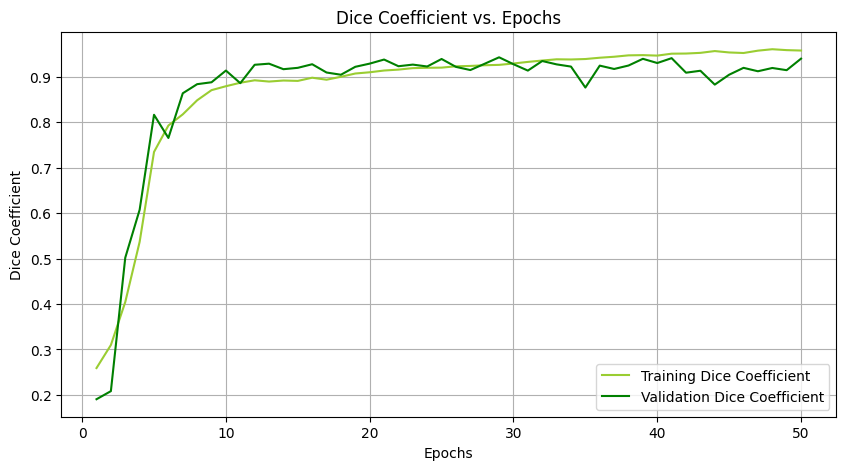

In [136]:
import matplotlib.pyplot as plt

# Extraer las métricas de entrenamiento y validación
dice_coefficient = history.history['dice_coefficient']
val_dice_coefficient = history.history['val_dice_coefficient']

# Crear un rango de épocas para el eje X
epochs = range(1, len(dice_coefficient) + 1)

# Graficar la métrica dice_coefficient
plt.figure(figsize=(10, 5))
plt.plot(epochs, dice_coefficient, color='yellowgreen', label='Training Dice Coefficient')
plt.plot(epochs, val_dice_coefficient, 'g', label='Validation Dice Coefficient')
plt.title('Dice Coefficient vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid()
plt.show()


1/1 [==============================] - 0s 167ms/step


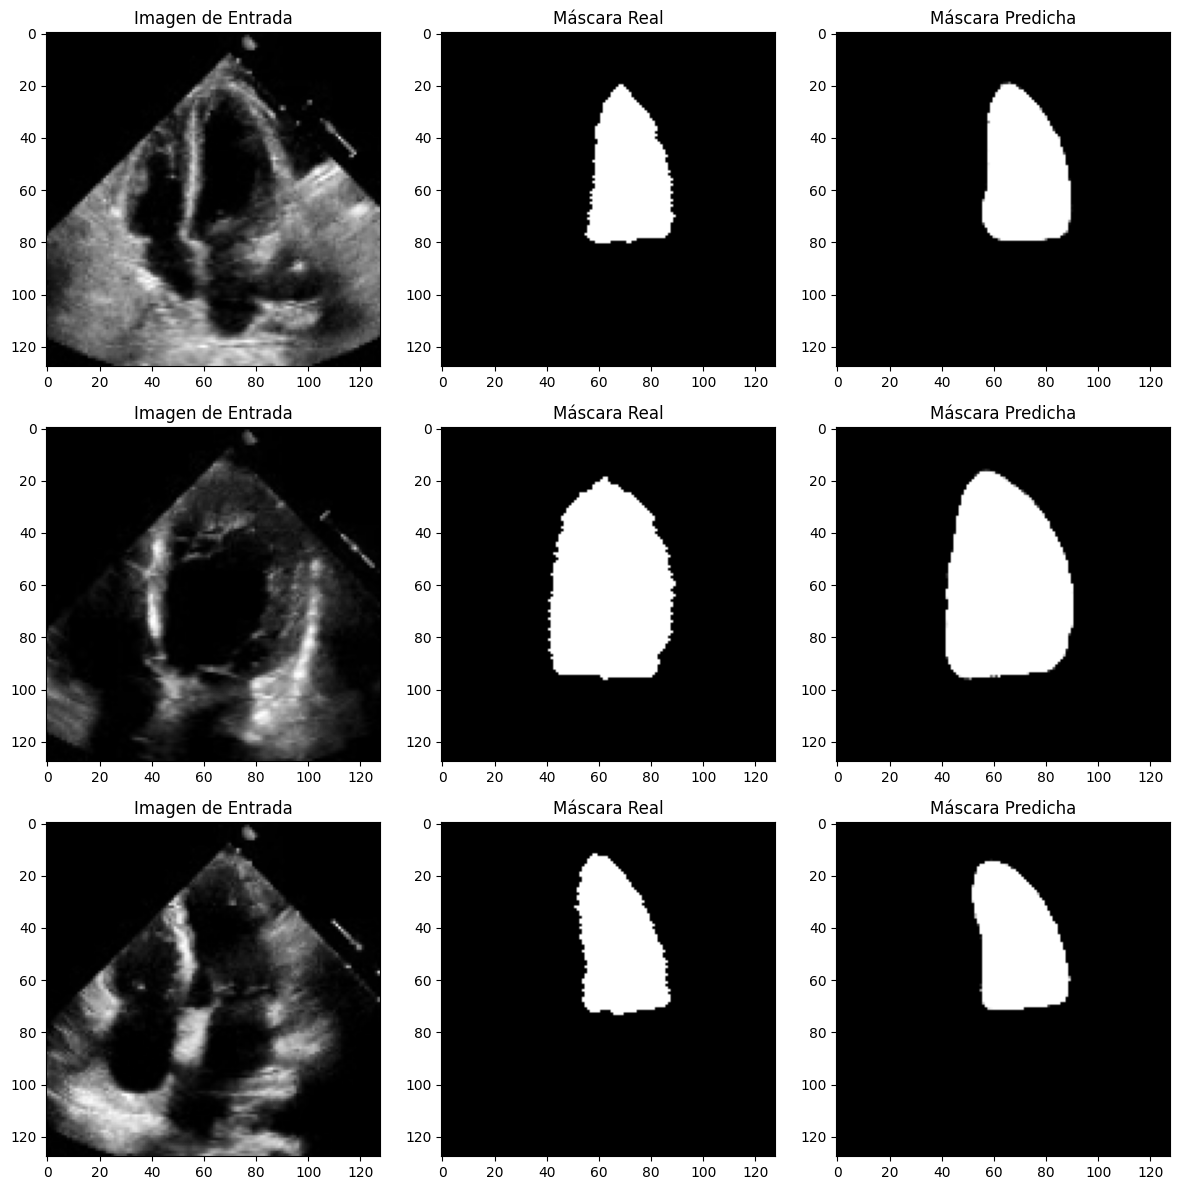

In [135]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

startFrame = 0

# Predecir máscaras para las primeras 3 imágenes de prueba
predicted_masks = model.predict(test_images[startFrame:startFrame + 3])

# Crear una figura con 3 columnas y 3 filas
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for i in range(3):
    # Primera columna: imagen de entrada
    axs[i, 0].imshow(test_images[i + startFrame], cmap='gray')
    axs[i, 0].set_title('Imagen de Entrada')

    # Tercera columna: máscara real
    axs[i, 1].imshow(test_masks[i + startFrame], cmap='gray')
    axs[i, 1].set_title('Máscara Real')
    
    # Segunda columna: máscara predicha (aplicando post-procesamiento)
    processed_mask = predicted_masks[i]
    axs[i, 2].imshow(processed_mask, cmap='gray')
    axs[i, 2].set_title('Máscara Predicha')

# Ajustar espaciado entre subgráficos
plt.tight_layout()

# Mostrar la figura
plt.show()